In [1]:
import nltk
import os, glob, math, time
import pandas as pd, numpy as np
from tqdm import tqdm

data = 'dataset'  
os.makedirs(data, exist_ok=True)
traincsv = os.path.join(data, 'train.csv')

print("Train CSV Path:", traincsv)

train_df = pd.read_csv(traincsv)
print(train_df.head())


Train CSV Path: dataset\train.csv
   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price  
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  


In [2]:
df = pd.read_csv(traincsv)
print("Rows:", len(df))
print(df.columns.tolist())
display(df.head())


Rows: 75000
['sample_id', 'catalog_content', 'image_link', 'price']


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [3]:
import requests
from urllib.parse import urlparse

def download_image(url, out_path, timeout=10):
    try:
        resp = requests.get(url, timeout=timeout)
        if resp.status_code == 200 and resp.content:
            with open(out_path, 'wb') as f:
                f.write(resp.content)
            return True, None
        else:
            return False, f"status_{resp.status_code}"
    except Exception as e:
        return False, str(e)


In [4]:
IMG_DIR = os.path.join(data, 'images')
os.makedirs(IMG_DIR, exist_ok=True)

MAX_DOWNLOAD = 2000  
downloaded = []
failed = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    if i >= MAX_DOWNLOAD:
        break
    url = row.get('image_link')
    if not isinstance(url, str) or url.strip()=='':
        failed.append((i, 'no_link'))
        continue
    parsed = urlparse(url)
    ext = os.path.splitext(parsed.path)[1]
    if ext.lower() not in ['.jpg','.jpeg','.png','.webp']:
        ext = '.jpg'
    outp = os.path.join(IMG_DIR, f"{i}{ext}")
    if os.path.exists(outp):
        downloaded.append((i,outp))
        continue
    ok, err = download_image(url, outp)
    if ok:
        downloaded.append((i,outp))
    else:
        failed.append((i, err))

print("Downloaded:", len(downloaded), "Failed:", len(failed))
print("Example failures:", failed[:10])


  3%|▎         | 2000/75000 [00:00<00:04, 17417.55it/s]

Downloaded: 2000 Failed: 0
Example failures: []


In [5]:
import cv2
from PIL import Image
import numpy as np

def read_image_rgb(path, target_size=None):
    try:
        img = Image.open(path).convert('RGB')
        if target_size is not None:
            img = img.resize(target_size)
        return np.array(img)
    except Exception as e:
        return None

akaze = cv2.AKAZE_create()

def extract_akaze_descriptors_from_path(path):
    img = read_image_rgb(path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kps, des = akaze.detectAndCompute(gray, None)
    return des


In [6]:
from sklearn.cluster import MiniBatchKMeans
sample = 64
maxs = 1000 
N = 256              

sampled_descs = []
count = 0
for idx, path in tqdm(downloaded[:maxs]):
    des = extract_akaze_descriptors_from_path(path)
    if des is None or len(des)==0:
        continue
    if des.shape[0] > sample:
        perm = np.random.choice(des.shape[0], sample, replace=False)
        sampled_descs.append(des[perm])
    else:
        sampled_descs.append(des)
    count += 1

if len(sampled_descs)==0:
    raise RuntimeError("No descriptors found. Check image downloads or AKAZE compatibility.")
all_des = np.vstack(sampled_descs)
print("Sampled descriptors shape:", all_des.shape)

kmeans = MiniBatchKMeans(n_clusters=N, random_state=42, batch_size=4096)
kmeans.fit(all_des)
print("KMeans fitted. n_clusters=", N)


100%|██████████| 1000/1000 [03:57<00:00,  4.22it/s]


Sampled descriptors shape: (63867, 61)
KMeans fitted. n_clusters= 256


In [7]:
def descriptors_to_bovw_hist(descriptors, kmeans):
    if descriptors is None or len(descriptors)==0:
        return np.zeros(kmeans.n_clusters, dtype=float)
    labels = kmeans.predict(descriptors)
    hist, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters+1))
    hist = hist.astype(float)
    if hist.sum()>0:
        hist = hist / hist.sum()
    return hist


In [8]:
X_list = []
y_list = []
paths_used = []
for idx, path in tqdm(downloaded):
    des = extract_akaze_descriptors_from_path(path)
    hist = descriptors_to_bovw_hist(des, kmeans)
    X_list.append(hist)
    y_list.append(df.at[idx, 'price'] if 'price' in df.columns else np.nan)
    paths_used.append(path)

X = np.vstack(X_list)
y = np.array(y_list, dtype=float)
print("X shape:", X.shape, "y shape:", y.shape)


100%|██████████| 2000/2000 [07:12<00:00,  4.63it/s]

X shape: (2000, 256) y shape: (2000,)


In [9]:
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
import joblib, os


valid_mask = ~np.isnan(y)
X = X[valid_mask]
y = y[valid_mask]
paths_used = [p for i,p in enumerate(paths_used) if valid_mask[i]]
print("Usable samples:", len(y))

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

Xtr, Xte, ytr, yte = train_test_split(Xs, y, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
reg.fit(Xtr, np.log1p(ytr))
pred_log = reg.predict(Xte)
pred = np.expm1(pred_log)
print("Regression MAE:", mean_absolute_error(yte, pred))
print("Regression R2 (log):", r2_score(np.log1p(yte), pred_log))


kb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_bin = kb.fit_transform(y.reshape(-1,1)).ravel().astype(int)
Xtr_c, Xte_c, ytr_c, yte_c = train_test_split(Xs, y_bin, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(Xtr_c, ytr_c)
acc = accuracy_score(yte_c, clf.predict(Xte_c))
print("Classification acc (bins):", acc)

os.makedirs(os.path.join(data,'models'), exist_ok=True)
joblib.dump(reg, os.path.join(data,'models','regressor_rf.joblib'))
joblib.dump(clf, os.path.join(data,'models','classifier_rf.joblib'))
joblib.dump(kmeans, os.path.join(data,'models','kmeans_bovw.joblib'))
joblib.dump(scaler, os.path.join(data,'models','scaler.joblib'))
joblib.dump(kb, os.path.join(data,'models','kbins.joblib'))
print("Saved models to", os.path.join(data,'models'))


Usable samples: 2000
Regression MAE: 15.285011083818096
Regression R2 (log): 0.10536984189007959
Classification acc (bins): 0.2725
Saved models to dataset\models


In [10]:
preds_logall = reg.predict(Xs)
preds_all = np.expm1(preds_logall)
preds_bin = clf.predict(Xs)

out_df = pd.DataFrame({
    'image_path': paths_used,
    'price_true': y,
    'price_pred': preds_all,
    'price_bin_pred': preds_bin
})
out_csv = os.path.join(data, 'labeled_prices.csv')
out_df.to_csv(out_csv, index=False)
print("Wrote labeled CSV:", out_csv)
display(out_df.head())


Wrote labeled CSV: dataset\labeled_prices.csv


,image_path,price_true,price_pred,price_bin_pred
0,dataset\images\0.jpg,4.89,7.240664,0
1,dataset\images\1.jpg,13.12,12.275983,2
2,dataset\images\2.jpg,1.97,4.699463,0
3,dataset\images\3.jpg,30.34,24.328720,3
4,dataset\images\4.jpg,66.49,40.144186,4


In [ ]:
from urllib.parse import urlparse
from concurrent.futures import ThreadPoolExecutor, as_completed

SAMPLE_SIZE = 2000  

test_df = pd.read_csv(os.path.join(data, 'test.csv')).head(SAMPLE_SIZE)
print(f"🔹 Memproses {len(test_df)} gambar pertama untuk uji coba pipeline")

pred_paths = []
X_test_list = []

def process_image(i, row):
    url = row.get('image_link')
    if not isinstance(url, str):
        return None, None
    
    parsed = urlparse(url)
    ext = os.path.splitext(parsed.path)[1]
    if ext.lower() not in ['.jpg', '.jpeg', '.png']:
        ext = '.jpg'

    outp = os.path.join(IMG_DIR, f"test_{i}{ext}")

    if not os.path.exists(outp):
        ok, _ = download_image(url, outp)
        if not ok:
            return None, None

    des = extract_akaze_descriptors_from_path(outp)
    hist = descriptors_to_bovw_hist(des, kmeans)
    return outp, hist

with ThreadPoolExecutor(max_workers=12) as executor:
    futures = {executor.submit(process_image, i, row): i for i, row in test_df.iterrows()}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing test images"):
        try:
            outp, hist = future.result()
            if outp is not None and hist is not None:
                pred_paths.append(outp)
                X_test_list.append(hist)
        except Exception as e:
            print(f"Error processing image: {e}")


print(f"\n Berhasil ekstraksi fitur dari {len(X_test_list)} gambar.")
X_test = scaler.transform(np.vstack(X_test_list))
pred_price = np.expm1(reg.predict(X_test))
pred_bins = clf.predict(X_test)

test_out = pd.DataFrame({
    'image_path': pred_paths,
    'predicted_price': pred_price,
    'predicted_bin': pred_bins
})

out_path = os.path.join(data, f'test_predictions_sample{SAMPLE_SIZE}.csv')
test_out.to_csv(out_path, index=False)
print(f"Hasil prediksi disimpan di: {out_path}")
display(test_out.head())


🔹 Memproses 2000 gambar pertama untuk uji coba pipeline


Processing test images: 100%|██████████| 2000/2000 [03:16<00:00, 10.16it/s]


 Berhasil ekstraksi fitur dari 2000 gambar.
Hasil prediksi disimpan di: dataset\test_predictions_sample2000.csv


,image_path,predicted_price,predicted_bin
0,dataset\images\test_8.jpg,13.026579,0
1,dataset\images\test_6.jpg,12.484933,2
2,dataset\images\test_3.jpg,14.711956,0
3,dataset\images\test_0.jpg,18.655694,2
4,dataset\images\test_2.jpg,18.428580,3


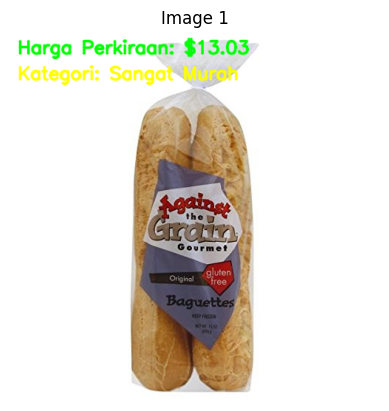

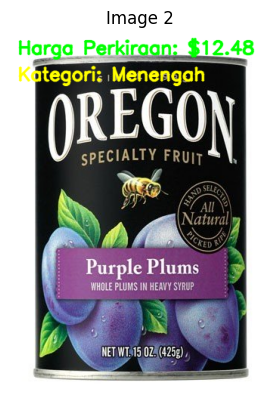

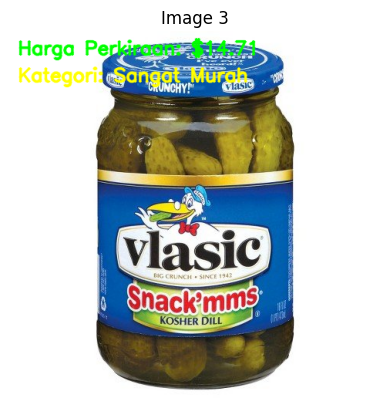

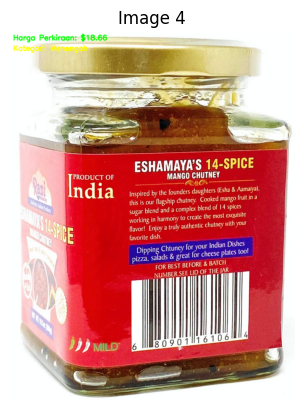

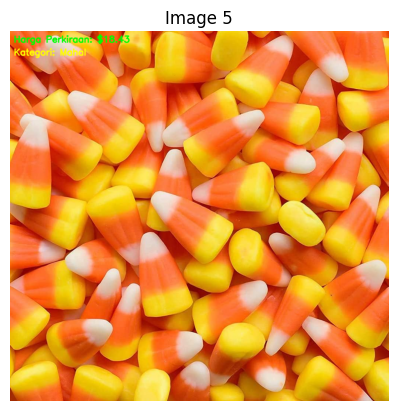

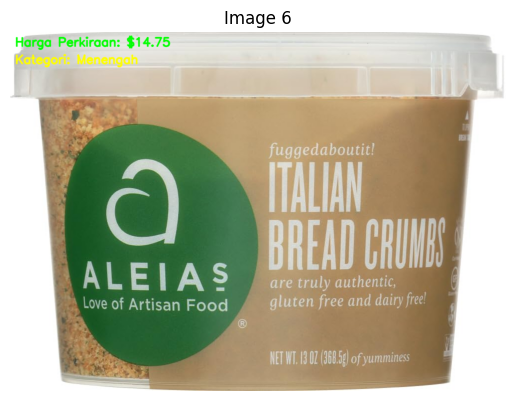

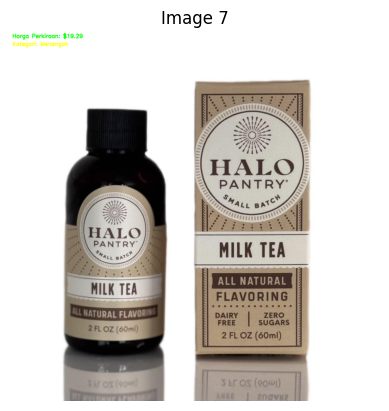

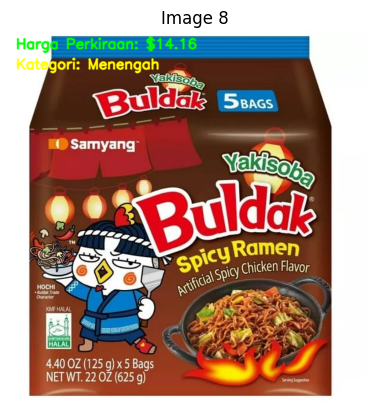

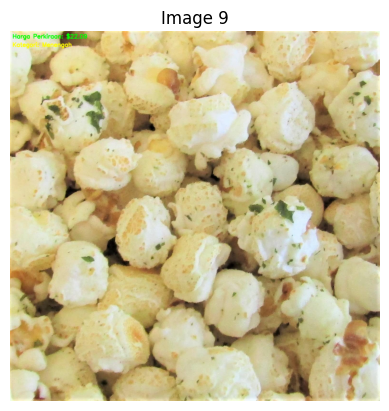

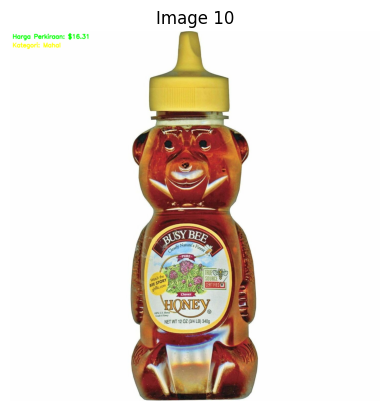

Semua gambar hasil prediksi disimpan di: dataset\predicted_images_readable


In [16]:
import cv2
import matplotlib.pyplot as plt

data = "dataset"
test_out = pd.read_csv(os.path.join(data, 'test_predictions_sample2000.csv'))

bin_labels = {
    0: "Sangat Murah",
    1: "Murah",
    2: "Menengah",
    3: "Mahal",
    4: "Sangat Mahal"
}

out_dir = os.path.join(data, "predicted_images_readable")
os.makedirs(out_dir, exist_ok=True)

for i, row in test_out.head(10).iterrows():
    img_path = row["image_path"]
    price = row["predicted_price"]
    bin_label = int(row["predicted_bin"])

    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    price_usd = f"${price:,.2f}" 
    category = bin_labels.get(bin_label, "Tidak diketahui")

    cv2.putText(img, f"Harga Perkiraan: {price_usd}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img, f"Kategori: {category}", (10, 65),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2, cv2.LINE_AA)

    out_path = os.path.join(out_dir, f"pred_readable_{i}.jpg")
    cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()

print(f"Semua gambar hasil prediksi disimpan di: {out_dir}")

